In [1]:
#import numpy and matplot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import keras 
import keras as kr 
# this are need for export the model al proto for be used in c#
from keras import backend as K
import tensorflow.compat.v1 as tf

Using TensorFlow backend.


In [3]:
# image generator for argumented data
from keras.preprocessing.image import ImageDataGenerator

In [4]:
# utility for split the data
from sklearn.model_selection import train_test_split

In [5]:
#Load Images 
x = []
with open("data/images.txt") as f:
    for line in f:
      x.append(np.asarray([float(x) for x in line.split()]))

In [6]:
# total number of images
len(x)

8298

In [7]:
# convert into np and reshape
x = np.asarray(x)
x = x.reshape(len(x),30,30,1)


In [8]:
# to float32
x = x.astype("float32")

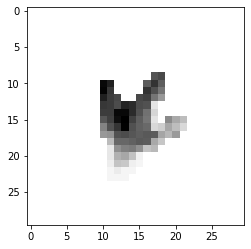

In [9]:
# check one image
plt.imshow(x[2250].reshape(30,30), cmap='gray')


In [10]:
# load labels
y = []
with open("data/labels.txt") as f:
    for line in f:
      y.append(int(line))


In [11]:
# transfor labels into np array
y = np.asarray(y)

In [12]:
# split labels into vectors of size 10
y = kr.utils.to_categorical(y, 13)

In [13]:
# split data into test and train
# 33% would be the test data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [14]:
# create model

model = kr.models.Sequential()
model.add(kr.layers.Conv2D(32,kernel_size=(3, 3),activation='relu',input_shape=(30,30,1)))
kr.layers.BatchNormalization(axis=-1)
model.add(kr.layers.Conv2D(32,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))

kr.layers.BatchNormalization(axis=-1)
model.add(kr.layers.Conv2D(64,kernel_size=(3, 3),activation='relu'))
kr.layers.BatchNormalization(axis=-1)
model.add(kr.layers.Conv2D(64,kernel_size=(3, 3),activation='relu'))
model.add(kr.layers.MaxPooling2D(pool_size=(2, 2),))

model.add(kr.layers.Flatten())
model.add(kr.layers.Dense(units=456, activation='relu'))
kr.layers.BatchNormalization()
model.add(kr.layers.Dropout(0.1))
model.add(kr.layers.Dense(units=13, activation='softmax'))


Instructions for updating:
Colocations handled automatically by placer.


In [15]:
#compile model
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [16]:
# need first and last layer name for use in c#
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)             

In [17]:
# create image generator
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
test_gen = ImageDataGenerator()

In [18]:
#epoch = 10
#history_callback = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=epoch, batch_size=100)

In [19]:
# Create image generator
train_generator = gen.flow(X_train, y_train, batch_size=64)
test_generator = test_gen.flow(X_test, y_test, batch_size=64)


In [20]:
#train 10 epoch
epoch =10
model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=epoch, 
                    validation_data=test_generator, validation_steps=10000//64)



Instructions for updating:
Use tf.cast instead.
Epoch 1/10
937/937 [==============================] - 14s 15ms/step - loss: 0.3436 - accuracy: 0.8877 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2/10
937/937 [==============================] - 10s 10ms/step - loss: 0.0207 - accuracy: 0.9940 - val_loss: 0.0013 - val_accuracy: 0.9992
Epoch 3/10
937/937 [==============================] - 10s 10ms/step - loss: 0.0125 - accuracy: 0.9961 - val_loss: 1.5701e-05 - val_accuracy: 1.0000
Epoch 4/10
937/937 [==============================] - 10s 10ms/step - loss: 0.0077 - accuracy: 0.9975 - val_loss: 1.0979e-05 - val_accuracy: 0.9996
Epoch 5/10
937/937 [==============================] - 10s 11ms/step - loss: 0.0088 - accuracy: 0.9973 - val_loss: 7.1341e-05 - val_accuracy: 0.9996
Epoch 6/10
937/937 [==============================] - 10s 10ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 3.5528e-05 - val_accuracy: 0.9998
Epoch 7/10
937/937 [==============================] - 10s 10ms/step - lo

In [21]:
# freeze function from stack overflow
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [22]:
# froze the graph
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 55 variables.
INFO:tensorflow:Converted 55 variables to const ops.


In [23]:
#save model in file as pb importable 
tf.train.write_graph(frozen_graph, "../model/", "gesture_model1.pb", as_text=False)

'../model/gesture_model1.pb'

In [24]:
# look at some generatoed images
x1,y1 = train_generator.next()

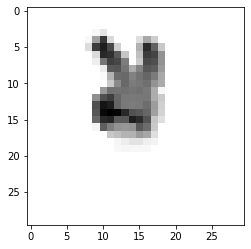

In [26]:


plt.imshow(x1[12].reshape(30,30), cmap='gray')

